# CV_LAB : Question 1
## author : Vishal Kashyap

In [2]:
# coordinate frame : x is towards right , y is down

In [2]:
## import necessary libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure

In [3]:
# load image with name as greyscale
im = cv2.imread('Dataset/Name_Arial_72.jpeg')
# as opencv loads in BGR format by default, we want to show it in RGB.
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

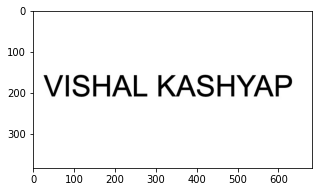

In [4]:
# check if image is loaded properly
figure(figsize=(5, 100))
plt.imshow(im)

* It can be seen that origin of image lies on the top left corner. To rotate the image we need to find origin and rotate each pixel about that. 
* Here x-axis will be column of image and y-axis will be row of image.

# Question 1 a


a) Write a function that takes as input an image I, rotates it by an angle θ1 and horizontally skews it by an angle, θ2. Write the matrix formulation for image rotation R(.) and skewing S(.). Define all the variables. Note that the origin of the coordinate system of the programming environment you use might be different from the one shown in the lectures.

## Try forward warping

In [4]:
# ***to decide size of new image just locate new coordiantes of 4 corners!!!

In [7]:
# function to rotate or shear image counter-clockwise by angle theta using forward warping
# input : im_old : image to rotate
#         theat : angle to rotate (counter-clockwise)
#         transformation matrix : this will control rotation or shear ('rotation' or 'shear')

# output : transformed image

def ICV_rotate_image_fwd(im_old, theta, transformation):
    
    # step 1 : find center of image = int(max_row/col /2)
    x_center = int(im_old.shape[1]/2.0)
    y_center = int(im_old.shape[0]/2.0)
    
    # step 2 : find new location of each pixel after rotation and fill new matrix
    # rotation matrix
    if transformation == "rotation":
        rot_mat = np.array([[np.cos(theta) , np.sin(theta)] , [-np.sin(theta) , np.cos(theta)]])
    if transformation == "shear":
        rot_mat = np.array([[1 , np.tan(theta)] , [0 , 1]])
    print("performing", transformation)
    
    # get transformaed coordinates for 4 corners of image to determine size of new image
    min_x,max_x = 1e9,-1e9
    min_y,max_y = 1e9,-1e9
    
    for i in [0,im_old.shape[0]-1]:
        for j in [0,im_old.shape[1]-1]:
            # old cordinates
            old_cordinate = np.array([j-x_center, i-y_center])
            # rotate to get new cordinates
            new_cordinate = np.matmul(rot_mat, old_cordinate)
            new_row = int(np.rint(new_cordinate[1]))
            new_col = int(np.rint(new_cordinate[0]))
            
            # find size of transformed image by looking at where the corners land
            if new_row < min_x:
                min_x = new_row
            if new_row > max_x:
                max_x = new_row
            if new_col < min_y:
                min_y = new_col
            if new_col > max_y:
                max_y = new_col
        
    
    # new rotated image , initially all grey
    im_new = np.zeros((int(max_x - min_x)+10,int(max_y-min_y)+10,3)) + 128
                      
    # center of transformed image
    x_center_new = int(im_new.shape[1]/2.0)
    y_center_new = int(im_new.shape[0]/2.0)
    
    #iterate through each pixel and rotate
    for i in range(im_old.shape[0]):
        for j in range(im_old.shape[1]):
            
            # rotate about center of image
            old_cordinate = np.array([j-x_center, i-y_center])
            new_cordinate = np.matmul(rot_mat, old_cordinate)
            
            # translate the center back to top-left of image
            new_cordinate = new_cordinate + np.array([x_center_new,y_center_new])
            
            # edge cases,
            # if new cordinate below 0 or new cordinate out of array dimension .. continue
            new_row = int(np.rint(new_cordinate[1]))
            new_col = int(np.rint(new_cordinate[0]))
            
            #  and store in new image array
            im_new[new_row,new_col,:] = im_old[i,j,:]
            
    return im_new.astype(int)
    

In [9]:
new_im = ICV_rotate_image_fwd(im, 0.2, 'rotation')

performing rotation


## Try inverse warping

In [10]:
# function to find the size of new images by looking at where the corners in old image land.

def ICV_size_new_image(transformation,theta,im_old,x_center,y_center):
    # forward rotation matrix
    if transformation == "rotation":
        rot_mat = np.array([[np.cos(theta) , np.sin(theta)] , [-np.sin(theta) , np.cos(theta)]])
    if transformation == "shear":
        rot_mat = np.array([[1 , np.tan(theta)] , [0 , 1]])

    # get transformaed coordinates for 4 corners of image to determine size of new image
    min_x,max_x = 1e9,-1e9
    min_y,max_y = 1e9,-1e9
    
    for i in [0,im_old.shape[0]-1]:
        for j in [0,im_old.shape[1]-1]:
            old_cordinate = np.array([j-x_center, i-y_center])
            new_cordinate = np.matmul(rot_mat, old_cordinate)
            new_row = int(np.rint(new_cordinate[1]))
            new_col = int(np.rint(new_cordinate[0]))

            if new_row < min_x:
                min_x = new_row
            if new_row > max_x:
                max_x = new_row
            if new_col < min_y:
                min_y = new_col
            if new_col > max_y:
                max_y = new_col
    
    return max_x,max_y,min_x,min_y

# function to rotate image clockwise by angle theta (inverse warping) using "NNI" or "BLI"
# input : transformation : whether we want to roatate or shear ("rotation","shear")
#         theta : angle to rotate (counter clockwise)
#         im_old : imge to transform
#         mode : if want to use NNI or BLI for interpolation
#         
# output : rotated image

def ICV_rotate_image_inv(im_old, theta, mode,transformation):

    # step 1 : find center of image = int(max_row/col /2)
    x_center = int(im_old.shape[1]/2.0)
    y_center = int(im_old.shape[0]/2.0)
    
    # step 2 : Use nearest neighbour interpolation to fill pixel values in new image
    
    # inverse rotation matrix
    if transformation == "rotation":
        rot_mat_inv = np.array([[np.cos(theta) , np.sin(theta)] , [-np.sin(theta) , np.cos(theta)]]).T
    if transformation == "shear":
        rot_mat_inv = np.array([[1 , -np.tan(theta)] , [0 , 1]])
    print("performing", transformation)
    
    # function to get size of new image based on where 4 corners in old image
    max_x,max_y,min_x,min_y = ICV_size_new_image(transformation,theta,im_old,x_center,y_center)
        
    # new rotated image , initially all grey
    im_new = np.zeros((int(max_x - min_x)+10,int(max_y-min_y)+10,3)) + 128.0
                      
    # center of transformed image
    x_center_new = int(im_new.shape[1]/2.0)
    y_center_new = int(im_new.shape[0]/2.0)
    
    #iterate through each pixel and rotate
    for i in range(im_new.shape[0]):
        for j in range(im_new.shape[1]):
            
            # image center wont rotate , so continue
            if(i==y_center_new and j==x_center_new):
                continue
            
            # inverese rotate pixel cordinates, to get original pixel cordinates
            new_cordinate = np.array([j-x_center_new, i-y_center_new])
            old_cordinate = np.matmul(rot_mat_inv, new_cordinate)
            
            # translate the center back to top-left of image
            old_cordinate = old_cordinate + np.array([x_center,y_center])
            
            # find nearest pixel to cordinate obatained after rotation.
            old_row = int(np.rint(old_cordinate[1]))
            old_col = int(np.rint(old_cordinate[0]))
            
            #  and store in new image array
            # perform nearest neighbour or bilinear interpolation depending on "mode"
            if mode == "NNI":
                
                # check if cordinates obtained after inverse rotation are out of image
                out_of_image = old_col >= im_old.shape[1] or old_row >= im_old.shape[0]
                if np.sum(old_cordinate<0) or out_of_image:
                    continue

                im_new[i,j,:] = im_old[old_row,old_col,:]
            
            # if we want to do bilinear interpolation to fill pixels
            if mode == "BLI":
                x1 = int(np.floor(old_cordinate[0]))
                x2 = int(np.ceil(old_cordinate[0]))
                y1 = int(np.floor(old_cordinate[1]))
                y2 = int(np.ceil(old_cordinate[1]))
                x0 = old_cordinate[0]
                y0 = old_cordinate[1]
                
                # check if any of the points, x1,x2,y1,y2 lies outside image, continue
                if(x1 < 0 or x2 >= im_old.shape[1]):
                    continue
                if(y1 < 0 or y2 >= im_old.shape[0]):
                    continue

                fQ11 = im_old[y1,x1,:]
                fQ12 = im_old[y2,x1,:]
                fQ21 = im_old[y1,x2,:]
                fQ22 = im_old[y2,x2,:]
                
                
                if transformation == "rotation":
                    
                    if(x1 == x2):
                        # no bilinear interpolation needed
                        fR1 = fQ11
                        fR2 = fQ22
                    else:
                        fR1 = (x2-x0)/(x2-x1)*fQ11 + (x0-x1)/(x2-x1)*fQ21
                        fR2 = (x2-x0)/(x2-x1)*fQ12 + (x0-x1)/(x2-x1)*fQ22
                    
                    if(y1 == y2):
                        # no bilinear interpolation needed
                        im_new[i,j,:] = fR1
                    else:
                        im_new[i,j,:] = (y2-y0)/(y2-y1)*fR1 + (y0-y1)/(y2-y1)*fR2
                
                # since in shear y coordinate remains same
                if transformation == "shear":
                    
                    # on center line image will have no shear, so fill old value for those points
                    if i==y_center_new:
                        
                        # check if i,j lies outside old image
                        if(old_row>=im_old.shape[0] or old_col>= im_old.shape[1]):
                            continue
                        im_new[i,j,:] = im_old[old_row,old_col,:]
                        continue
                        
                    im_new[i,j,:] = (x2-x0)/(x2-x1)*fQ11 + (x0-x1)/(x2-x1)*fQ21
                
            
    return im_new.astype(int)
    

### Nearest neighbour interpolation

performing rotation


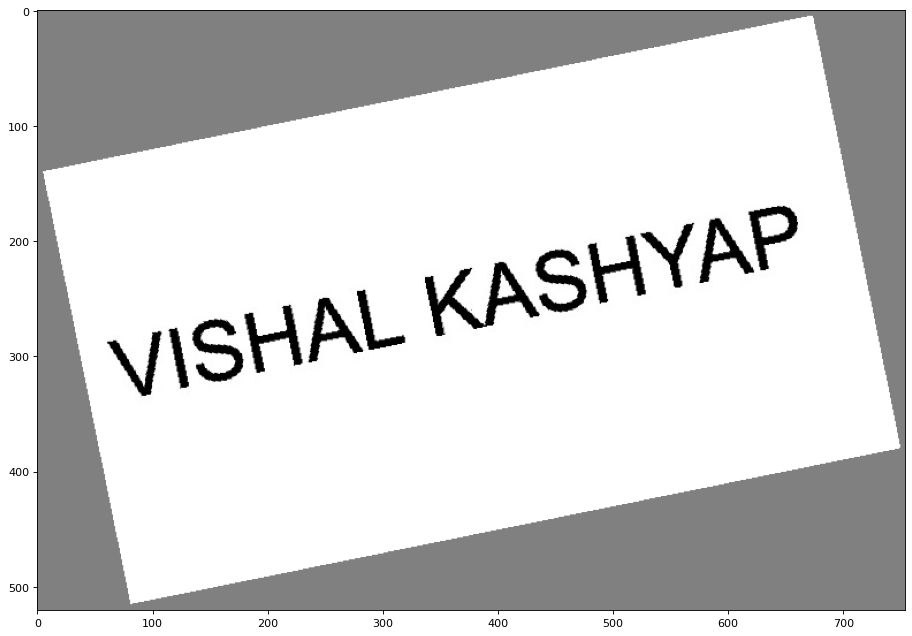

In [11]:
im_NNI = ICV_rotate_image_inv(im, 0.2, "NNI","rotation")
figure(figsize=(14, 11), dpi=80)
plt.imshow(im_NNI)

performing shear


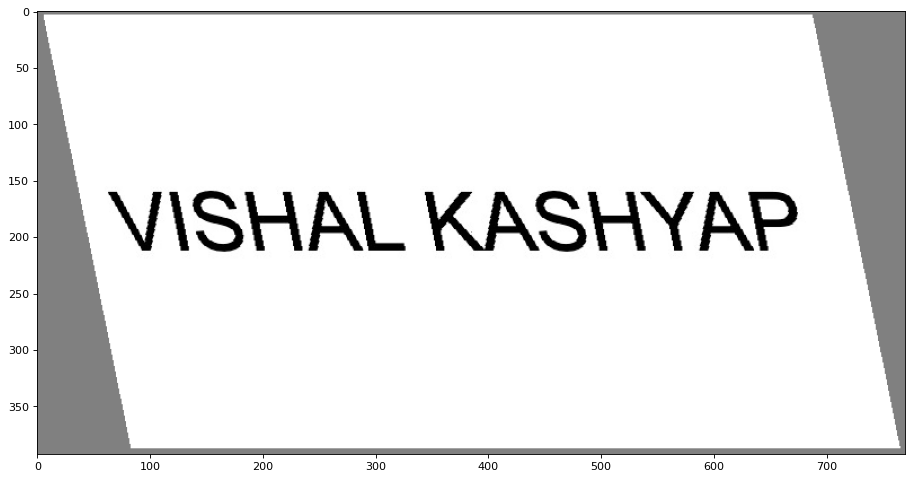

In [12]:
im_NNI = ICV_rotate_image_inv(im, 0.2, "NNI","shear")
figure(figsize=(14, 11), dpi=80)
plt.imshow(im_NNI)

## Bilinear Interpolation

performing rotation


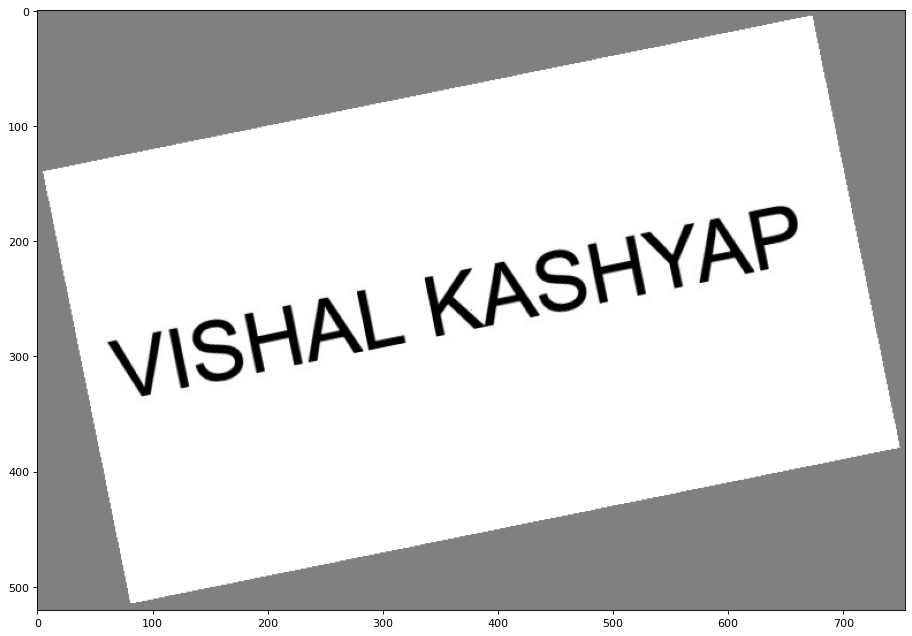

In [13]:
im_BLI = ICV_rotate_image_inv(im, 0.2, "BLI","rotation")
figure(figsize=(14, 11), dpi=80)
plt.imshow(im_BLI)

performing shear


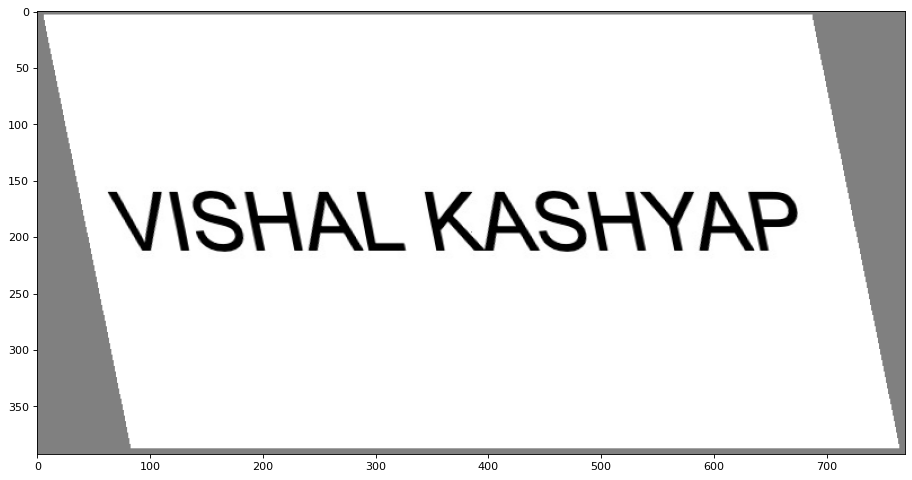

In [14]:
im_BLI = ICV_rotate_image_inv(im, 0.2, "BLI","shear")
figure(figsize=(14, 11), dpi=80)
plt.imshow(im_BLI)

# Question 1 b

b) Create an image that contains your name written in Arial, point 72, capital letters. Rotate clockwise the image you created by 30, 60, 120 and -50 degrees. Skew the same image by 10, 40 and 60 degrees. Complete the process so that all the pixels have a value. Discuss in the report the advantages and disadvantages of different approaches.

performing rotation
performing rotation
performing rotation
performing rotation


Text(0.5, 1.0, 'Rotate by -50 degree clockwise')

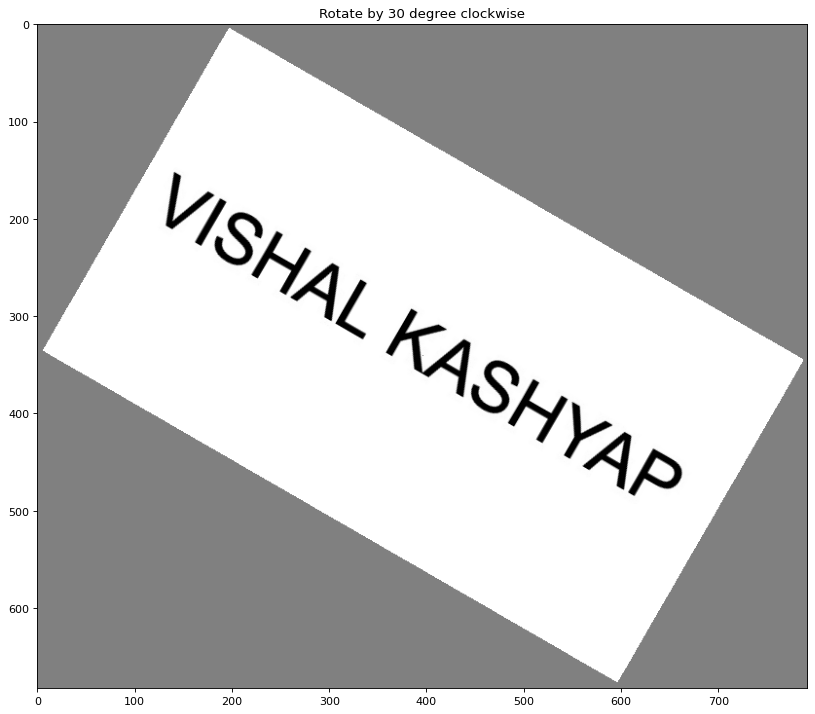

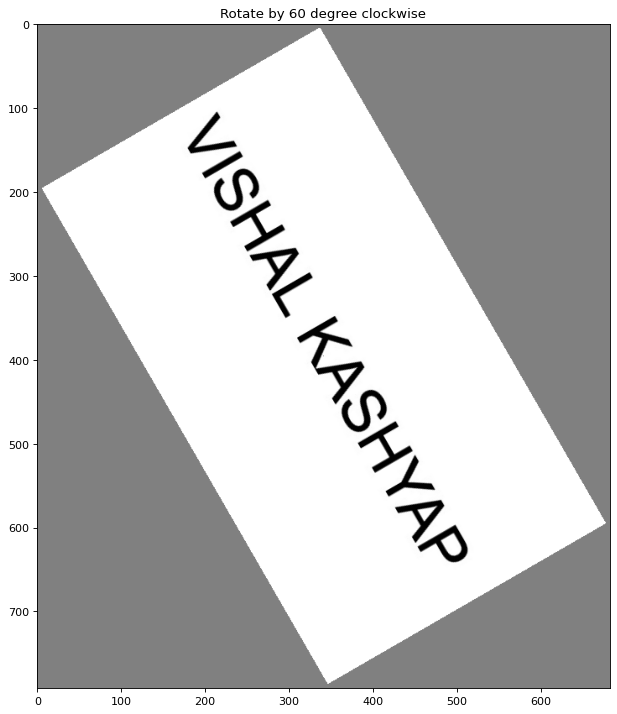

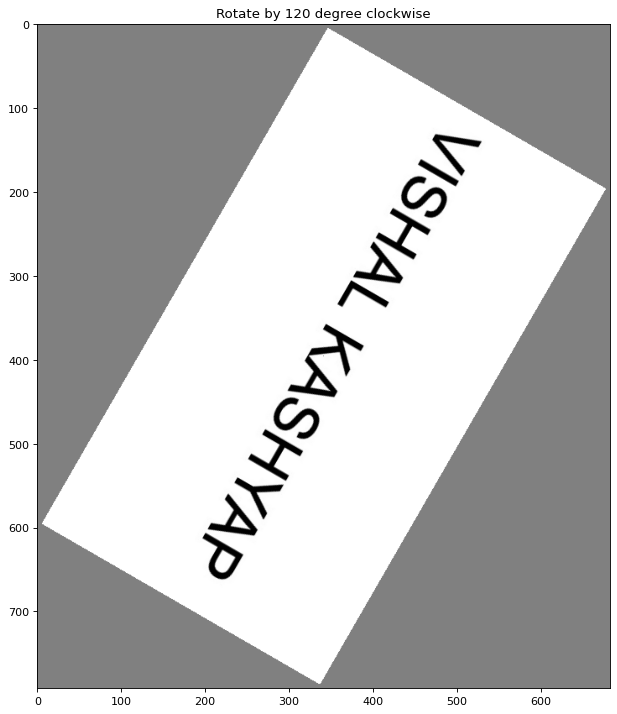

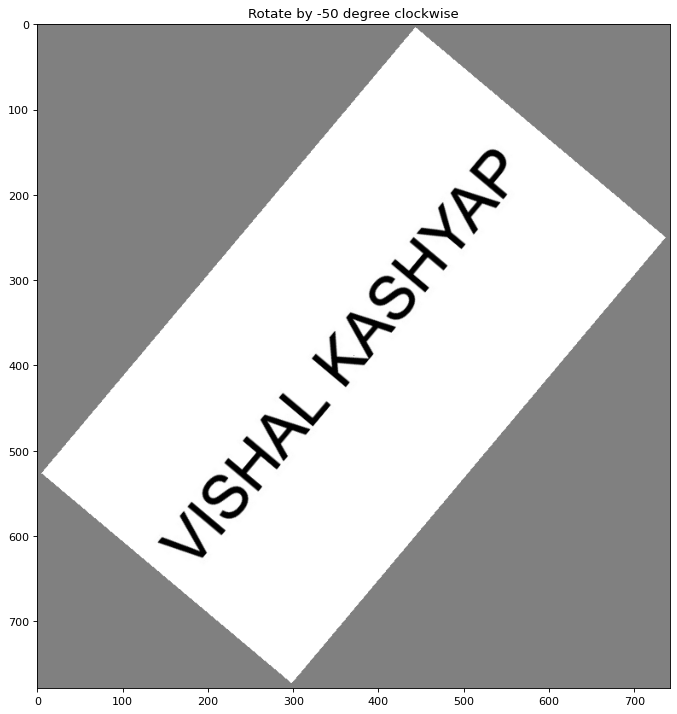

In [15]:
# rotate by 30
im_BLI = ICV_rotate_image_inv(im, -30/180*np.pi, "BLI","rotation")
figure(figsize=(14, 11), dpi=80)
plt.imshow(im_BLI)
plt.title("Rotate by 30 degree clockwise")

# rotate by 60
im_BLI = ICV_rotate_image_inv(im, -60/180*np.pi, "BLI","rotation")
figure(figsize=(14, 11), dpi=80)
plt.imshow(im_BLI)
plt.title("Rotate by 60 degree clockwise")

# rotate by 120
im_BLI = ICV_rotate_image_inv(im, -120/180*np.pi, "BLI","rotation")
figure(figsize=(14, 11), dpi=80)
plt.imshow(im_BLI)
plt.title("Rotate by 120 degree clockwise")

# rotate by -50
im_BLI = ICV_rotate_image_inv(im, 50/180*np.pi, "BLI","rotation")
figure(figsize=(14, 11), dpi=80)
plt.imshow(im_BLI)
plt.title("Rotate by -50 degree clockwise")

performing shear
performing shear
performing shear


Text(0.5, 1.0, 'shear by 60 degree clockwise')

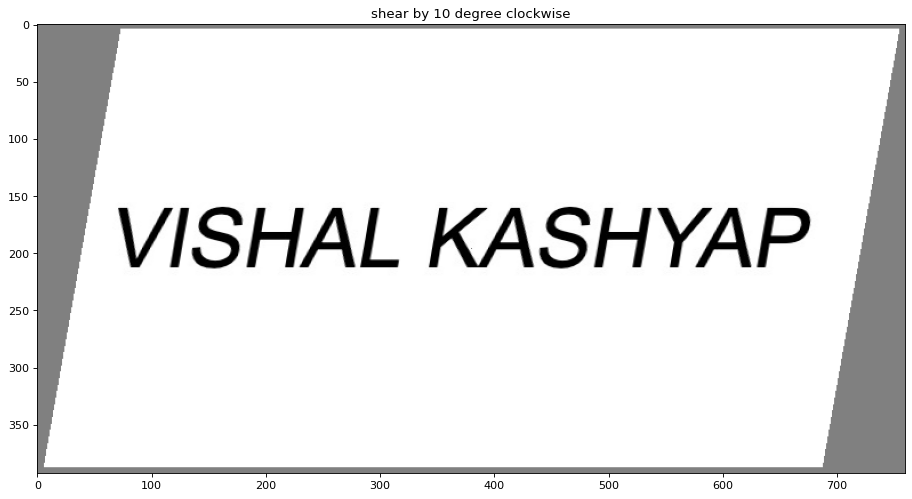

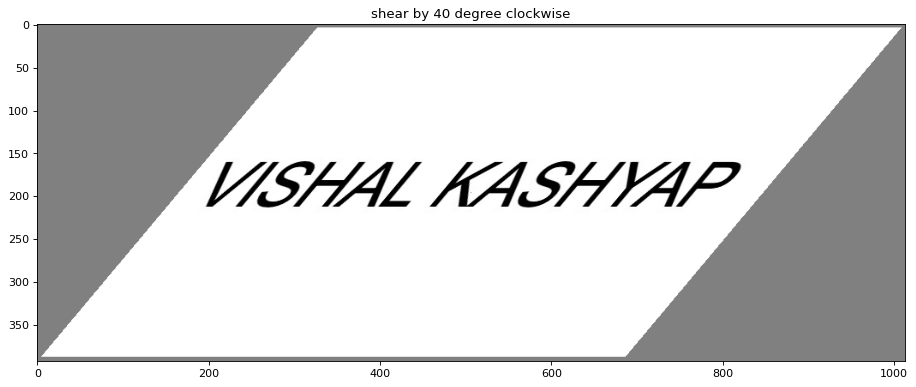

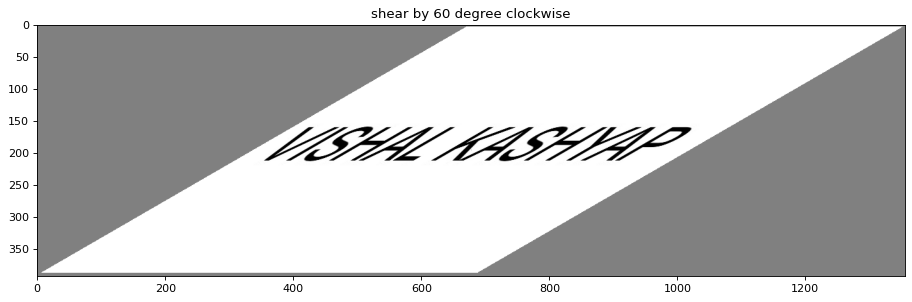

In [16]:
# skew by 10
im_BLI = ICV_rotate_image_inv(im, -10/180*np.pi, "BLI","shear")
figure(figsize=(14, 14), dpi=80)
plt.imshow(im_BLI)
plt.title("shear by 10 degree clockwise")

# rotate by 40
im_BLI = ICV_rotate_image_inv(im, -40/180*np.pi, "BLI","shear")
figure(figsize=(14, 14), dpi=80)
plt.imshow(im_BLI)
plt.title("shear by 40 degree clockwise")

# rotate by 60
im_BLI = ICV_rotate_image_inv(im, -60/180*np.pi, "BLI","shear")
figure(figsize=(14, 14), dpi=80)
plt.imshow(im_BLI)
plt.title("shear by 60 degree clockwise")


# Part C

c) Analyse the results when you change the order of the two operators: R(S(I)) and S(R(I)).
i) Rotate the image by θ1 = 20 clockwise and then skew the result by θ2 = 50.
ii) Skew the image by θ2 = 50 and then rotate the result by θ1 = 20 clockwise.
Are the results of (i) and (ii) the same? Why?

performing rotation
performing shear


Text(0.5, 1.0, 'Rotate by 20 degree clockwise and then shear by 50 degree')

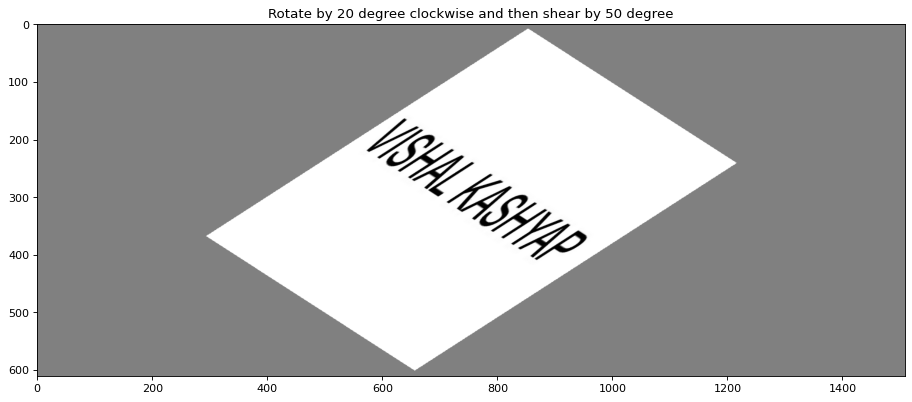

In [17]:
#Rotate the image by θ1 = 20 clockwise and then skew the result by θ2 = 50
im_BLI_rotate = ICV_rotate_image_inv(im, -20/180*np.pi, "BLI","rotation")
im_BLI_rotshear = ICV_rotate_image_inv(im_BLI_rotate,  -50/180*np.pi, "BLI","shear")

figure(figsize=(14, 11), dpi=80)
plt.imshow(im_BLI_rotshear)
plt.title("Rotate by 20 degree clockwise and then shear by 50 degree")

performing shear
performing rotation


Text(0.5, 1.0, 'sheasr by 50 degree clockwise and then rotate by 20 degree')

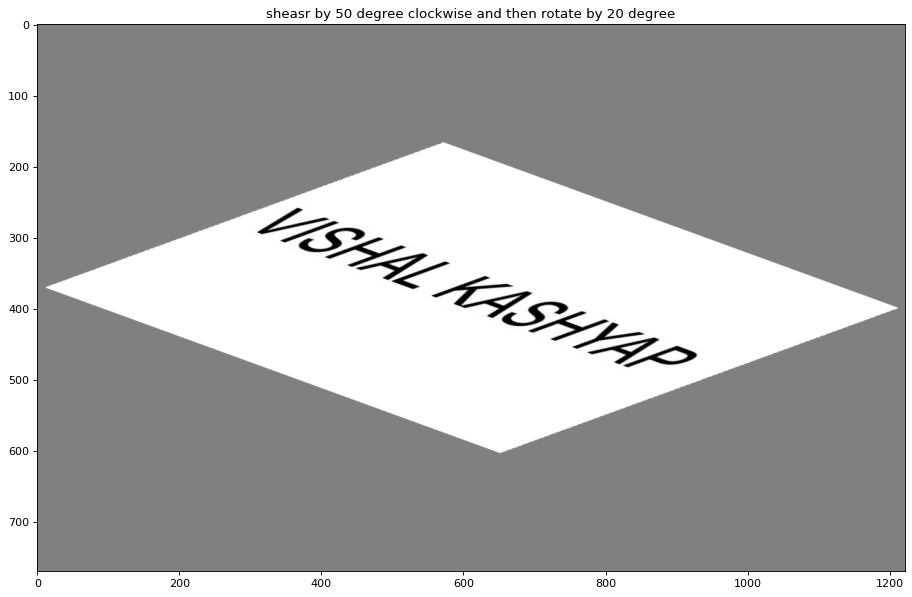

In [18]:
#Skew the image by θ2 = 50 and then rotate the result by θ1 = 20 clockwise.
im_BLI_skew = ICV_rotate_image_inv(im, -50/180*np.pi, "BLI","shear")
im_BLI_shearrot = ICV_rotate_image_inv(im_BLI_skew,  -20/180*np.pi, "BLI","rotation")

figure(figsize=(14, 11), dpi=80)
plt.imshow(im_BLI_shearrot)
plt.title("sheasr by 50 degree clockwise and then rotate by 20 degree")